# Machine Learning Project

### Mehdi Lotfian - 99105689

### https://colab.research.google.com/drive/1VLO_UHcdQCXqSwpWtzEaup7Bsp4jn1BL?usp=sharing

#### import libraries

In [120]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import fasttext
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
import string
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### load data from drive

In [2]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/data-train.csv', "/content/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/data-train.csv'

#### download stop words and punktuations

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### make dataframe

In [7]:
df = pd.read_csv('./data-train.csv')
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
155043,155044,8485,Santa Clause 2 ' is wondrously creative .,4
155044,155045,8485,' is wondrously creative .,2
155045,155046,8485,is wondrously creative .,3
155046,155047,8485,is wondrously creative,4


#### describe data

In [8]:
df.describe()

,PhraseId,SentenceId,Sentiment
count,155048.000000,155048.000000,155048.000000
mean,77524.500000,4050.787575,2.063838
std,44758.646606,2485.057572,0.893967
min,1.000000,1.000000,0.000000
25%,38762.750000,1849.000000,2.000000
50%,77524.500000,3987.000000,2.000000
75%,116286.250000,6199.000000,3.000000
max,155048.000000,8485.000000,4.000000


#### preprocess data

In [9]:
def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):

    normalized_tokens = word_tokenize(text)

    if stopword_removal:
        # Remove stopwords in English and also the given domain stopwords
        stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
        domain_stopwords = [x.lower() for x in stopwords_domain]
        normalized_tokens = [word for word in normalized_tokens if word.lower() not in domain_stopwords + stopwords]

    if punctuation_removal:
        # Remove punctuations
        normalized_tokens = [word for word in normalized_tokens if word not in string.punctuation]

    if lower_case:
        # Convert everything to lowercase and filter based on a min length
        normalized_tokens = [word.lower() for word in normalized_tokens if len(word) > minimum_length]
    else:
        normalized_tokens = [word for word in normalized_tokens if len(word) > minimum_length]

    return normalized_tokens

In [17]:
phrases = list(df['Phrase'])
sentiments = list(df['Sentiment'])

phrases_processed = [' '.join(preprocess_text(p)) for p in phrases]
data_dict = {'Phrase': phrases_processed, 'Sentiment': sentiments}

preprocessed_df = pd.DataFrame(data_dict)
preprocessed_df

,Phrase,Sentiment
0,series escapades demonstrating adage good goos...,1
1,series escapades demonstrating adage good goose,2
2,series,2
3,,2
4,series,2
...,...,...
155043,santa clause wondrously creative,4
155044,wondrously creative,2
155045,wondrously creative,3
155046,wondrously creative,4


In [18]:
preprocessed_df['Sentiment'].value_counts()

2    79064
3    32714
1    27084
4     9160
0     7026
Name: Sentiment, dtype: int64

## Approach 1: TF-IDF

In [134]:
tfd = TfidfVectorizer()
data_matrix = tfd.fit_transform(preprocessed_df['Phrase'])
data_matrix

<155048x15120 sparse matrix of type '<class 'numpy.float64'>'
	with 625579 stored elements in Compressed Sparse Row format>

#### train test split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, preprocessed_df['Sentiment'], test_size=0.2)

#### fit and evaluate naive bayes on the processed data (approach 1)

In [99]:
from sklearn.model_selection import GridSearchCV
parameters = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
}
grid_search= GridSearchCV(mnb_model_sklearn, parameters)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=MultinomialNB(force_alpha=True),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)})

In [101]:
y_predict_mnb = grid_search.predict(X_test)
y_predict_mnb

array([2, 2, 2, ..., 4, 2, 1])

In [102]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("f1-score-macro: " + str(f1_score(y_test, y_predict_mnb, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_predict_mnb, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_predict_mnb, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_predict_mnb, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_predict_mnb, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_predict_mnb, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_predict_mnb)))

f1-score-macro: 0.488178864190972
f1-score-micro: 0.609771041599484
precision-score-macro: 0.526374464003683
precision-score-micro: 0.609771041599484
recall-score-macro: 0.4644973640861149
recall-score-micro: 0.609771041599484
accuracy-score: 0.609771041599484


In [103]:
print(classification_report(y_test, y_predict_mnb))

              precision    recall  f1-score   support

           0       0.46      0.32      0.38      1426
           1       0.49      0.41      0.45      5429
           2       0.69      0.79      0.73     15841
           3       0.51      0.49      0.50      6510
           4       0.48      0.32      0.38      1804

    accuracy                           0.61     31010
   macro avg       0.53      0.46      0.49     31010
weighted avg       0.59      0.61      0.60     31010



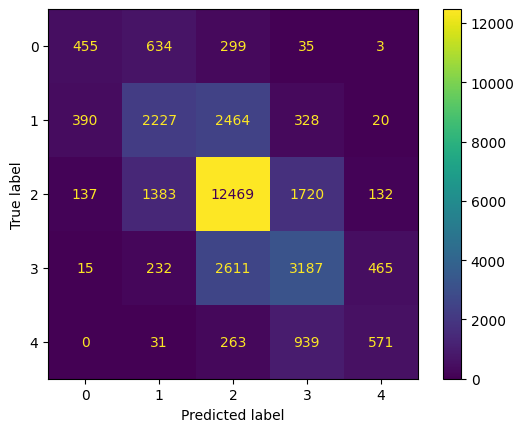

In [104]:
cm = confusion_matrix(y_test, y_predict_mnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### fit and evalute logistic regression

In [106]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

lr = LogisticRegression(multi_class='ovr')

clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(multi_class='ovr'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [107]:
y_pred_lr = clf.predict(X_test)
y_pred_lr

array([2, 2, 2, ..., 4, 2, 1])

In [111]:
print("f1-score-macro: " + str(f1_score(y_test, y_pred_lr, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_pred_lr, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_pred_lr, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_pred_lr, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_pred_lr, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_pred_lr, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_pred_lr)))

f1-score-macro: 0.5156987237099668
f1-score-micro: 0.636117381489842
precision-score-macro: 0.5626603279876791
precision-score-micro: 0.636117381489842
recall-score-macro: 0.4873521738459069
recall-score-micro: 0.636117381489842
accuracy-score: 0.636117381489842


In [112]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.50      0.36      0.42      1426
           1       0.52      0.40      0.46      5429
           2       0.69      0.85      0.76     15841
           3       0.56      0.45      0.50      6510
           4       0.53      0.37      0.44      1804

    accuracy                           0.64     31010
   macro avg       0.56      0.49      0.52     31010
weighted avg       0.62      0.64      0.62     31010



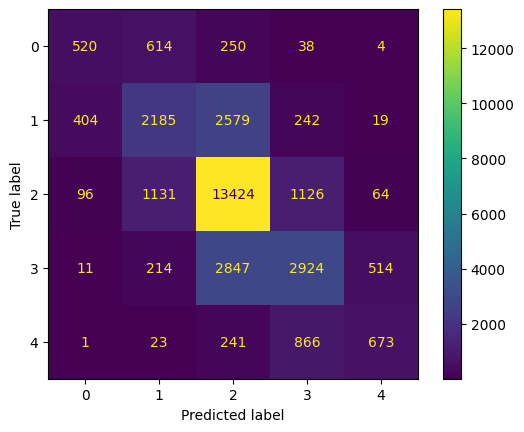

In [113]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### fit and evalute decision tree

In [122]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 50]}

dt = DecisionTreeClassifier()

clf = GridSearchCV(dt, param_grid)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50]})

In [123]:
y_pred_dt = clf.predict(X_test)
y_pred_dt

array([2, 2, 2, ..., 2, 2, 2])

In [124]:
print("f1-score-macro: " + str(f1_score(y_test, y_pred_dt, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_pred_dt, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_pred_dt, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_pred_dt, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_pred_dt, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_pred_dt, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_pred_dt)))

f1-score-macro: 0.13493460979570904
f1-score-micro: 0.509061593034505
precision-score-macro: 0.10181231860690101
precision-score-micro: 0.509061593034505
recall-score-macro: 0.2
recall-score-micro: 0.509061593034505
accuracy-score: 0.509061593034505


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Approach 2 (fasttext with classic algorithms and nueral net)

In [33]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393374 sha256=0b626d237e9329d5525f0738ee67c629c0c9d999223543fd8fc3f3ac68dca71c
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [41]:
with open(r'my_text.txt', 'w') as fp:
    for text in phrases_processed:
        fp.write("%s\n" % text)
    print('Done')

Done


In [43]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """
        self.model = fasttext.train_unsupervised('my_text.txt', model=self.method, dim=100)

    def get_query_embedding(self, query, tf_idf_vectorizer):
        """
        get the embedding of the query. You can use the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
        Parameters
        ----------
        query: str
        tf_idf_vectorizer: TfidfVectorizer
        Returns embedding of the query
        """
        query_embed = self.model.get_sentence_vector(query)
        return query_embed

    def save_FastText_model(self, path='FastText_model.bin'):
        self.model.save_model(path)

    def load_FastText_model(self, path="FastText_model.bin"):
        self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()

In [49]:
FastText_model = FastText(preprocessor=phrases_processed)
#FastText_model.prepare(phrases_processed, mode='train', save=True)
FastText_model.prepare(phrases_processed, mode='load')

#### get vectors of each word using fast text

In [50]:
embeddings = []
for phrase in phrases_processed:
  embeddings.append(FastText_model.model.get_sentence_vector(phrase))

In [51]:
embeddings[0]

array([-0.01832999, -0.04377057, -0.04358413,  0.03483986,  0.0561858 ,
        0.04736236, -0.08835591, -0.00859419, -0.02675325,  0.06950314,
       -0.09789348, -0.06520741, -0.01129297,  0.08295813, -0.00247112,
        0.00029125, -0.03094422,  0.11768447, -0.044657  , -0.08277138,
        0.00949296, -0.05065781,  0.00435395, -0.00782073,  0.05476574,
       -0.02662758,  0.04036947,  0.0129228 ,  0.00898838,  0.06661793,
        0.02912495, -0.04824452, -0.04914222, -0.13980018, -0.13155794,
        0.01918579, -0.01790343, -0.03966211,  0.03862493, -0.00391143,
        0.06991068,  0.10255531, -0.03845802,  0.00543201, -0.05131325,
        0.00339296,  0.06054854,  0.05622844, -0.05569289, -0.01378454,
       -0.11277413, -0.03337117, -0.05404892, -0.01418558,  0.05179127,
       -0.0767866 , -0.09374851,  0.00557957,  0.0070263 , -0.01450259,
        0.01803439, -0.00998808,  0.1179543 ,  0.02332797, -0.00680564,
       -0.02065902, -0.13785222,  0.07897691,  0.02632846,  0.03

In [52]:
len(embeddings), len(sentiments)

(155048, 155048)

#### split data for classic ways

In [129]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, preprocessed_df['Sentiment'], test_size=0.2)

In [115]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

#### fit and evaluate naive bayes

In [92]:
from sklearn.model_selection import GridSearchCV
parameters = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
}
grid_search= GridSearchCV(mnb_model_sklearn, parameters)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=MultinomialNB(force_alpha=True),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)})

In [93]:
y_predict_mnb = grid_search.predict(X_test)

In [94]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("f1-score-macro: " + str(f1_score(y_test, y_predict_mnb, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_predict_mnb, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_predict_mnb, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_predict_mnb, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_predict_mnb, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_predict_mnb, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_predict_mnb)))

f1-score-macro: 0.1347305389221557
f1-score-micro: 0.5079006772009029
precision-score-macro: 0.10158013544018059
precision-score-micro: 0.5079006772009029
recall-score-macro: 0.2
recall-score-micro: 0.5079006772009029
accuracy-score: 0.5079006772009029


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### fit and evaluate logistic regression

In [116]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

lr = LogisticRegression(multi_class='ovr')

clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(multi_class='ovr'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [117]:
y_pred_lr = clf.predict(X_test)
y_pred_lr

array([1, 1, 0, ..., 1, 3, 4])

In [118]:
print("f1-score-macro: " + str(f1_score(y_test, y_pred_lr, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_pred_lr, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_pred_lr, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_pred_lr, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_pred_lr, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_pred_lr, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_pred_lr)))

f1-score-macro: 0.25646180595184254
f1-score-micro: 0.2781360851338278
precision-score-macro: 0.3298288133171484
precision-score-micro: 0.2781360851338278
recall-score-macro: 0.3430395413065242
recall-score-micro: 0.2781360851338278
accuracy-score: 0.2781360851338278


In [127]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.10      0.31      0.15      1375
           1       0.24      0.56      0.34      5489
           2       0.82      0.12      0.22     15786
           3       0.31      0.39      0.34      6540
           4       0.18      0.33      0.23      1820

    accuracy                           0.28     31010
   macro avg       0.33      0.34      0.26     31010
weighted avg       0.54      0.28      0.26     31010



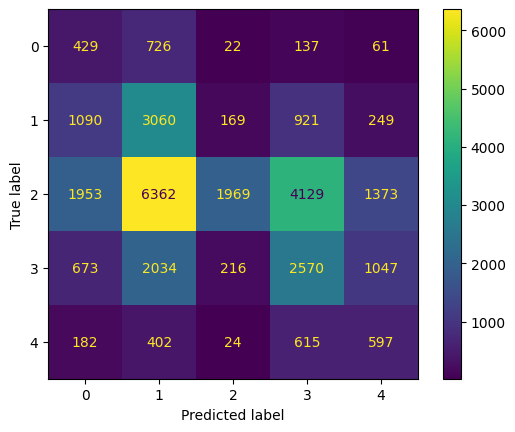

In [128]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [130]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 50]}

dt = DecisionTreeClassifier()

clf = GridSearchCV(dt, param_grid)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50]})

In [131]:
y_pred_dt = clf.predict(X_test)
y_pred_dt

array([0, 4, 2, ..., 2, 1, 1])

In [132]:
print("f1-score-macro: " + str(f1_score(y_test, y_pred_dt, average='macro')))
print("f1-score-micro: " + str(f1_score(y_test, y_pred_dt, average='micro')))
print("precision-score-macro: " + str(precision_score(y_test, y_pred_dt, average='macro')))
print("precision-score-micro: " + str(f1_score(y_test, y_pred_dt, average='micro')))
print("recall-score-macro: " + str(recall_score(y_test, y_pred_dt, average='macro')))
print("recall-score-micro: " + str(recall_score(y_test, y_pred_dt, average='micro')))
print("accuracy-score: " + str(accuracy_score(y_test, y_pred_dt)))

f1-score-macro: 0.45234216721091325
f1-score-micro: 0.5565301515640116
precision-score-macro: 0.4510102431041111
precision-score-micro: 0.5565301515640116
recall-score-macro: 0.4560778229679013
recall-score-micro: 0.5565301515640116
accuracy-score: 0.5565301515640116


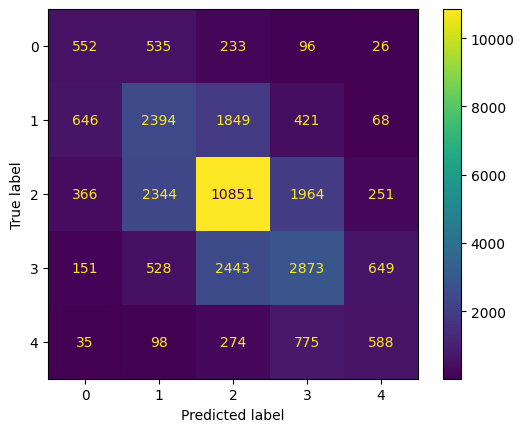

In [133]:
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## nueral net

In [53]:
class PapersDataSet(Dataset):
    def __init__(self, embeddings: list, labels: list):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, i):
        return self.embeddings[i], self.labels[i]

#### split dataset

In [56]:
dataset = PapersDataSet(embeddings, sentiments)

train_size = int(0.8 * len(dataset)) + 2
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [57]:
len(train_dataset[0][0]), len(val_dataset[0][0]), len(test_dataset[0][0])

(100, 100, 100)

In [58]:
len(train_dataset), len(val_dataset), len(test_dataset)

(124040, 15504, 15504)

### build, train and evulate the model

In [75]:
class ClassifierModel(nn.Module):
    def __init__(self, in_features=100, num_classes=3):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.batch_norm(x)
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClassifierModel().to(device)

In [77]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    """
    Evaluate the model on the given dataloader. used for validation and test
    Parameters
    ----------
    model: nn.Module
    criterion: nn.Module
    dataloader: torch.utils.data.DataLoader
    test_mode: bool
        If True, the function will print 'Test' instead of 'Validation'
    Returns
    -------
    eval_loss: float
        The loss on the given dataloader
    predicted_labels: list
        The predicted labels
    true_labels: list
        The true labels
    f1_score_macro: float
        The f1 score on the given dataloader
    """
    eval_loss = 0.0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            eval_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    f1_score_macro = f1_score(true_labels, predicted_labels, average='macro')

    if test_mode:
        print('Test set: Average loss: {:.4f}, F1 score (macro): {:.4f}'.format(eval_loss, f1_score_macro))
    else:
        print('Validation set: Average loss: {:.4f}, F1 score (macro): {:.4f}'.format(eval_loss, f1_score_macro))

    return eval_loss, predicted_labels, true_labels, f1_score_macro


In [82]:
"""
Train the model for num_epochs epochs
epoch_true and epoch_all are used to calculate the accuracy.
epoch_true is the number of correct predictions and epoch_all is the total number of predictions in the epoch
"""
num_epochs = 50

train_loss_arr, val_loss_arr = [], []
f1_macro_scores_val = []
f1_macro_scores_train = []
for epoch in range(num_epochs):
    start_time = time()
    predicted_labels_train = []
    true_labels_train = []
    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0

    model.train()

    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, labels) in pbar:
            optimizer.zero_grad()
            x = x.to(device)
            labels = labels.to(device)
            output = model(x)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            epoch_true += (predicted == labels).sum().item()
            epoch_all += x.size(0)
            predicted_labels_train.extend(predicted.cpu().numpy())
            true_labels_train.extend(labels.cpu().numpy())

    model.eval()

    f1_score_macro_train = f1_score(true_labels_train, predicted_labels_train, average='macro')
    val_loss, predicted_labels, true_labels, f1_score_macro = eval_epoch(model, criterion, val_loader)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    f1_macro_scores_val.append(f1_score_macro)
    f1_macro_scores_train.append(f1_score_macro_train)

    end_time = time()

    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
          f"Train Loss: {train_loss:.4f}\t"
          f"Validation Loss: {val_loss:.4f}\t F1 score macro: {f1_score_macro}")


  0%|          | 0/3877 [00:00<?, ?it/s]


IndexError: ignored